## $R^2$ Test
<div class="alert alert-info">
Goal: To fit One 2D gaussian to the FOXSI3 SLF data corrected by darks and check fits with the R Square Test.
<div>

$R^2$
--

$R^2\equiv 1 - \frac{SS_{res}}{SS_{tot}}$  
with  $SS_{res}=\sum_i (y_i - f_i)^2$  and  $SS_{tot}=\sum_i (y_i - \overline{y})^2$  
  
The closest is $R^2$ to 1, the better is the fit of the function. Full information about this **Coefficient of determination** can be found in https://en.wikipedia.org/wiki/Coefficient_of_determination  

The Chi square test is not used here because it has many problems when a large set of data is close to zero, as is our case far from the center of the PSF.

In [192]:
def RSquared(data,model):
    ## The closest to 1, the better is the fit.
    ss_err=(model.fit_info['fvec']**2).sum()
    ss_tot=((data-data.mean())**2).sum()
    return 1-(ss_err/ss_tot)

In [193]:
RSquared(data, fit2DG)

0.8946502848374472

(1048576,)

In [179]:
aux = copy.deepcopy(fit2DG.fit_info['fvec'])
aux[G1.flatten() == 0.0] = 0.0

#aux[np.nonzero(G1.flatten())] / G1.flatten()[np.nonzero(G1.flatten())]

/Users/Kamilobu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Kamilobu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


nan

In [188]:
aux = fit2DG.fit_info['fvec']/G1.flatten()
aux[np.isfinite(aux)]

/Users/Kamilobu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/Kamilobu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/Kamilobu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([ 1.00000000e+000,  1.00000000e+000, -2.49422157e+306, ...,
       -1.84822069e+305, -6.09194452e+307,  1.00000000e+000])

In [190]:
from scipy.stats import fisher_exact

In [191]:
fisher_exact?

In [4]:
fit2DG.fit_info?

### Import Packages:

In [1]:
from astropy import wcs
from astropy.io import fits as pyfits
from ndcube import NDCube
from astropy.visualization import ImageNormalize, MinMaxInterval, LogStretch, LinearStretch
from astropy.modeling import models, fitting
from mpl_toolkits import mplot3d
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

### Workspace:

#### Fit of the three 2D-gaussians

In [2]:
''' Plate scale '''
distance = 2. * u.m ## FOXSI focal distance
CCD_PIXEL_PITCH = 13.5 * u.micron ## Andor CCD Pitch in microns
binning = 2. ## binning used for collecting data.
plate_scale = np.arctan(binning * CCD_PIXEL_PITCH / distance).to(u.arcsec) ## in arcsec

''' Path to the folder where to find your data and darks: '''
folder = '/Users/Kamilobu/Desktop/Developer/foxsi3_optics_cal/data/'

''' File names: '''
filename = 'kFOXSI3_X10-Test_CCD_T2Sx6_10kV_0p02mA_0mmZ.fits'  ## name of your data fits file.
darkfilename = 'Dark1_FOXSI3_X10-Test_CCD_T2Sx6_10kV_0p02mA_+15mmZ.fits'  ## name of your darks fits file.
## These are fits files containing six frames each of 1024x1024 pixels taken at the SLF
## using the Andor camera and the Mo X-ray source. Voltages,Currents and Integration Times are 
## indicated over the names of the files.

## Read fits files using astropy.io.fits
fits = pyfits.open(folder+filename)
darkfits = pyfits.open(folder+darkfilename)

## Create data array corrected by darks:
data = np.average(fits[0].data, axis=0) - np.average(darkfits[0].data, axis=0)

''' Create the WCS information '''
wcs_dict = {
    'CTYPE1':'HPLT-TAN', ## To use sunpy this needs to be in helioporject coord.
    'CTYPE2':'HPLN-TAN', ## Although strange, it does not affect any of the analysis.
    'CUNIT1':'arcsec',
    'CUNIT2':'arcsec',
    'CDELT1': plate_scale.value, ## Plate scale in arcsec
    'CDELT2': plate_scale.value, ## Plate scale in arcsec
    'CRPIX1':0,
    'CRPIX2':0,
    'CRVAL1': 0,
    'CRVAL2': 0,
    'NAXIS1': data.shape[0],
    'NAXIS2': data.shape[1]
}
input_wcs = wcs.WCS(wcs_dict)

''' Create NDCube '''
datacube = NDCube(data, input_wcs)
max_pixel = np.unravel_index(np.argmax(datacube.data), datacube.data.shape)
fov = [20, 20] ## [px,px]

''' Definition of Two 2D-Gaussians function '''
@models.custom_model
def ThreeGaussians(x, y,
                 x_mean=0, y_mean=0, theta=0,
                 amp1=0, x1_stddev=0, y1_stddev=0, ## Gauss1 param
                 amp2=0, x2_stddev=0, y2_stddev=0, ## Gauss2 param
                 amp3=0, x3_stddev=0, y3_stddev=0, ## Gauss3 param
                 offset=0): ## offset
    ''' Constrain positive values for the amplitudes '''
    if amp1 < 0:
        amp1 = 1e12
    if amp2 < 0:
        amp2 = 1e12
    if amp3 < 0:
        amp3 = 1e12

    '''Define Sum of Gauss funtions'''
    g1 = models.Gaussian2D(amp1, x_mean, y_mean, x1_stddev, y1_stddev, theta)
    #g2 = models.Gaussian2D(amp2, x_mean, y_mean, x2_stddev, y2_stddev, theta)
    #g3 = models.Gaussian2D(amp3, x_mean, y_mean, x3_stddev, y3_stddev, theta)
    ''' Defining Offset '''
    #oset = models.Const2D(amplitude=offset)
    return g1(x,y) #+ g2(x,y) + g3(x,y) + oset(x,y)

## Make X,Y,Z data for the TWO 2D-Gaussians:
Xg, Yg = np.mgrid[0:datacube.data.shape[0], 0:datacube.data.shape[1]]

''' Fit Three 2D-Gaussians '''
## Initial Guess :
ThreeG_guess = ThreeGaussians(x_mean=max_pixel[0], y_mean=max_pixel[1], theta=0,
                          amp1=0.65*np.max(datacube.data),
                          amp2 = 0.25*np.max(datacube.data),
                          amp3 = 0.09*np.max(datacube.data),
                          x1_stddev=2, y1_stddev=2,
                          x2_stddev=2, y2_stddev=2,
                          x3_stddev=2, y3_stddev=2,offset=0)

## Finding best fit:
fit2DG = fitting.LevMarLSQFitter()
ThreeG_out = fit2DG(ThreeG_guess, Xg, Yg, datacube.data, maxiter=320) ## maxiter keyword is the max number of iterations.
Zout = ThreeG_out(Xg, Yg)

## Individual Gaussian Functions:
g1 = models.Gaussian2D(ThreeG_out.amp1.value, ThreeG_out.x_mean.value, 
                       ThreeG_out.y_mean.value, ThreeG_out.x1_stddev.value, 
                       ThreeG_out.y1_stddev.value, ThreeG_out.theta.value)
#g2 = models.Gaussian2D(ThreeG_out.amp2.value, ThreeG_out.x_mean.value, 
#                       ThreeG_out.y_mean.value, ThreeG_out.x2_stddev.value, 
#                       ThreeG_out.y2_stddev.value, ThreeG_out.theta.value)
#g3 = models.Gaussian2D(ThreeG_out.amp3.value, ThreeG_out.x_mean.value, 
#                       ThreeG_out.y_mean.value, ThreeG_out.x3_stddev.value, 
#                       ThreeG_out.y3_stddev.value, ThreeG_out.theta.value)
### Individual Gaussian Arrays:
G1 = g1(Xg, Yg)
#G2 = g2(Xg, Yg)
#G3 = g3(Xg, Yg)

**fit2DG.fit_info** contains the values returned by `scipy.optimize.leastsq` for the most recent fit. See the `scipy.optimize.leastsq` documentation for details on the meaning of these values.

Returns  
x : ndarray  
    The solution (or the result of the last iteration for an unsuccessful
    call).  
cov_x : ndarray  
    Uses the fjac and ipvt optional outputs to construct an
    estimate of the jacobian around the solution. None if a
    singular matrix encountered (indicates very flat curvature in
    some direction).  This matrix must be multiplied by the
    residual variance to get the covariance of the
    parameter estimates -- see curve_fit.  
infodict : dict  
    a dictionary of optional outputs with the key s:  
  
    ``nfev``
        The number of function calls
    ``fvec``
        The function evaluated at the output
    ``fjac``
        A permutation of the R matrix of a QR
        factorization of the final approximate
        Jacobian matrix, stored column wise.
        Together with ipvt, the covariance of the
        estimate can be approximated.
    ``ipvt``
        An integer array of length N which defines
        a permutation matrix, p, such that
        fjac*p = q*r, where r is upper triangular
        with diagonal elements of nonincreasing
        magnitude. Column j of p is column ipvt(j)
        of the identity matrix.
    ``qtf``
        The vector (transpose(q) * fvec).

In [48]:
fit2DG.fit_info['fvec'].shape

(1048576,)

#### Plotting

#### Plot Sinlge 2D Gaussian Fit:

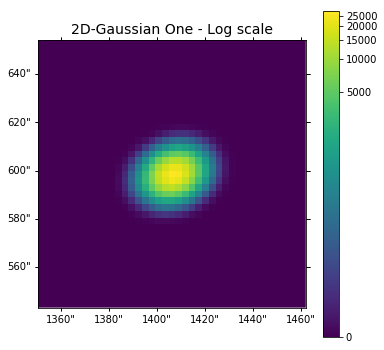

In [9]:
# Create ImageNormalize objects:
normLogT = ImageNormalize(Zout, interval=MinMaxInterval(),stretch=LogStretch())
normLog1 = ImageNormalize(G1, interval=MinMaxInterval(),stretch=LogStretch())

''' Plotting '''
fig, ax1 = plt.subplots(figsize=(6,6),subplot_kw=dict(projection=datacube.wcs))
## Gaussian One:
im1 = ax1.imshow(G1, origin='lower', cmap=plt.cm.viridis,norm=normLog1)
cbar1 = fig.colorbar(im1,ax=ax1)
ax1.set_xlim(max_pixel[1]-fov[1], max_pixel[1]+fov[1])
ax1.set_ylim(max_pixel[0]-fov[0], max_pixel[0]+fov[0])
ax1.set_title('2D-Gaussian One - Log scale',fontsize=14)
plt.show()

##### Plot Flat Fitted Gaussians 

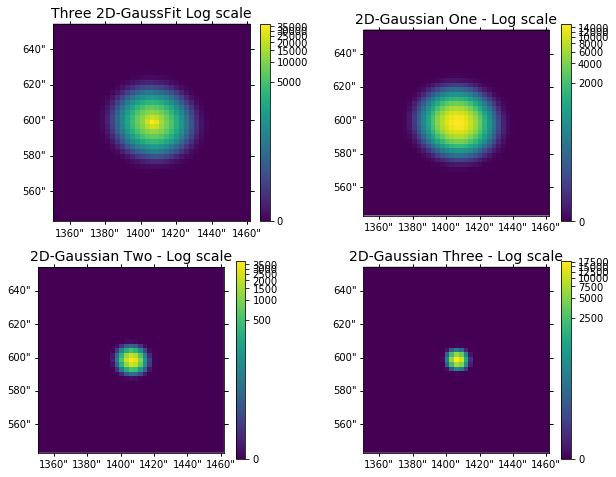

The amplitud ratios for the three 2D-Gaussians are: A1 = 0.41134279276148605, A2 = 0.1029809293884691, and 0.48567627785004486.
Offset = -0.9607780452200742


In [3]:
# Create ImageNormalize objects:
normLogT = ImageNormalize(Zout, interval=MinMaxInterval(),stretch=LogStretch())
normLog1 = ImageNormalize(G1, interval=MinMaxInterval(),stretch=LogStretch())
normLog2 = ImageNormalize(G2, interval=MinMaxInterval(),stretch=LogStretch())
normLog3 = ImageNormalize(G3, interval=MinMaxInterval(),stretch=LogStretch())

''' Plotting '''
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,8),
                                             subplot_kw=dict(projection=datacube.wcs))
fig.subplots_adjust(wspace = 0.4) ## Sets space between subplots to avoid overlap
## Best fit of the all three gaussians:
im1 = ax1.imshow(Zout, origin='lower', cmap=plt.cm.viridis,norm=normLogT)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_xlim(max_pixel[1]-fov[1], max_pixel[1]+fov[1])
ax1.set_ylim(max_pixel[0]-fov[0], max_pixel[0]+fov[0])
ax1.set_title('Three 2D-GaussFit Log scale',fontsize=14)
## Gaussian One:
im2 = ax2.imshow(G1, origin='lower', cmap=plt.cm.viridis,norm=normLog1)
cbar2 = fig.colorbar(im2,ax=ax2)
ax2.set_xlim(max_pixel[1]-fov[1], max_pixel[1]+fov[1])
ax2.set_ylim(max_pixel[0]-fov[0], max_pixel[0]+fov[0])
ax2.set_title('2D-Gaussian One - Log scale',fontsize=14)
## Gaussian Two:
im3 = ax3.imshow(G2, origin='lower', cmap=plt.cm.viridis,norm=normLog2)
cbar3 = fig.colorbar(im3,ax=ax3)
ax3.set_xlim(max_pixel[1]-fov[1], max_pixel[1]+fov[1])
ax3.set_ylim(max_pixel[0]-fov[0], max_pixel[0]+fov[0])
ax3.set_title('2D-Gaussian Two - Log scale',fontsize=14)
## Gaussian Two:
im4 = ax4.imshow(G3, origin='lower', cmap=plt.cm.viridis,norm=normLog3)
cbar4 = fig.colorbar(im4,ax=ax4)
ax4.set_xlim(max_pixel[1]-fov[1], max_pixel[1]+fov[1])
ax4.set_ylim(max_pixel[0]-fov[0], max_pixel[0]+fov[0])
ax4.set_title('2D-Gaussian Three - Log scale',fontsize=14)
plt.show()

''' Print what the amplitud ratios are '''
print('The amplitud ratios for the three 2D-Gaussians are: A1 = {0}, A2 = {1}, and {2}.'
      .format(ThreeG_out.amp1.value/(ThreeG_out.amp1.value+ThreeG_out.amp2.value+ThreeG_out.amp3.value),
              ThreeG_out.amp2.value/(ThreeG_out.amp1.value+ThreeG_out.amp2.value+ThreeG_out.amp3.value),
              ThreeG_out.amp3.value/(ThreeG_out.amp1.value+ThreeG_out.amp2.value+ThreeG_out.amp3.value),
       ))
print('Offset = {0}'.format(ThreeG_out.offset.value))

##### Plot  3D Fitted Gaussians

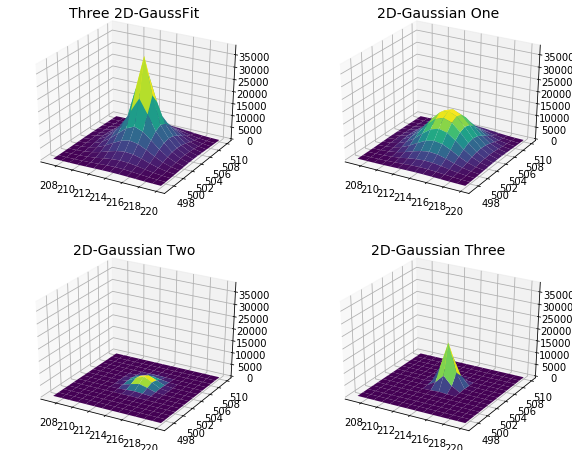

In [4]:
''' Clipping data '''
fov = [7,7]
sXg = Xg[max_pixel[0]-fov[0]:max_pixel[0]+fov[0],max_pixel[1]-fov[1]:max_pixel[1]+fov[1]]
sYg = Yg[max_pixel[0]-fov[0]:max_pixel[0]+fov[0],max_pixel[1]-fov[1]:max_pixel[1]+fov[1]]
sZout = ThreeG_out(sXg, sYg)
sG1 = g1(sXg, sYg)
sG2 = g2(sXg, sYg)
sG3 = g3(sXg, sYg)

''' 3D plotting '''
## Uncomment this line if you want interactivity
#%matplotlib notebook
%matplotlib inline

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,8),
                                             subplot_kw=dict(projection='3d'))
ax1.plot_surface(sXg,sYg,sZout,cmap=plt.cm.viridis)
ax1.set_title('Three 2D-GaussFit',fontsize=14)
ax1.set_zlim3d(0, sZout.max())
ax2.plot_surface(sXg,sYg,sG1,cmap=plt.cm.viridis)
ax2.set_title('2D-Gaussian One',fontsize=14)
ax2.set_zlim3d(0, sZout.max())
ax3.plot_surface(sXg,sYg,sG2,cmap=plt.cm.viridis)
ax3.set_title('2D-Gaussian Two',fontsize=14)
ax3.set_zlim3d(0, sZout.max())
ax4.plot_surface(sXg,sYg,sG3,cmap=plt.cm.viridis)
ax4.set_title('2D-Gaussian Three',fontsize=14)
ax4.set_zlim3d(0, sZout.max())
plt.show()

##### Plot Difference Data vs Fit

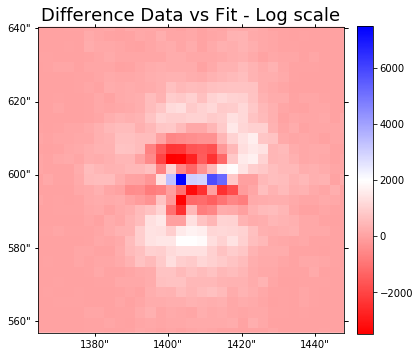

In [5]:
fov = [15,15]
fig, ax1 = plt.subplots(figsize=(6,6),subplot_kw=dict(projection=datacube.wcs))
im1 = ax1.imshow(datacube.data-Zout, origin='lower', cmap=plt.cm.bwr_r)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_xlim(max_pixel[1]-fov[1], max_pixel[1]+fov[1])
ax1.set_ylim(max_pixel[0]-fov[0], max_pixel[0]+fov[0])
ax1.set_title('Difference Data vs Fit - Log scale',fontsize=18)
plt.show()